In [154]:
from matplotlib import pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

Projekt zaliczeniowy PSI- Piotr Kubacki Temat: Przewidywanie zawału na podstawie danych medycznych

In [155]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
# del data['id']
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

Sprawdźmy unikalne wartości w kolumnach kategorycznych

In [156]:
for col in (data['gender'],data['ever_married'],data['work_type'],data['Residence_type'],data['smoking_status']):
    print(col.unique())

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [157]:
data['smoking_status'].replace('Unknown',np.nan, inplace=True)

Zwizualizujemy brakujące dane

In [158]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation='90')
    fig=sns.barplot(ms.index, ms["Percent"],color="green",alpha=0.8)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    return ms

C:\Users\sch03\anaconda3\envs\podstawy_sztucznej_inteligencji\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,Total,Percent
smoking_status,1544,30.215264
bmi,201,3.933464


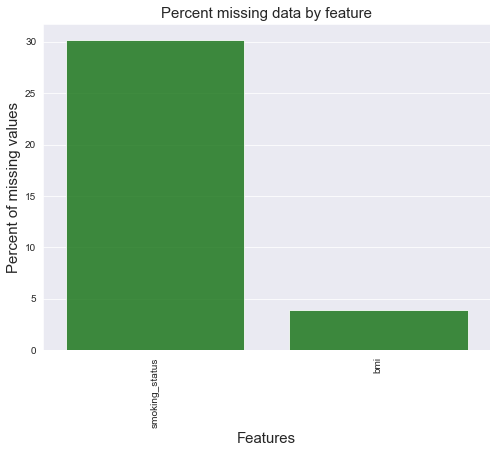

In [159]:
missingdata(data)

Trzeba coś zrobić z nanami:
* w bmi jest mało do uzupełnienia. Wrzucimy tam średnią
* smoking_status ma dużo braków, ale z uwagi na istotność kolumny uznajemy, że 30% jest akceptowalne do uzupełnienia. Za nany wrzucimy losowe wartości z ['formerly smoked' 'never smoked' 'smokes']

In [160]:
import numpy as np
filldata = ['formerly smoked', 'never smoked', 'smokes']
data['smoking_status']=data['smoking_status'].map(lambda l: l if not pd.isnull(l) else np.random.choice(filldata))

In [161]:
mean_test = data['bmi'].mean()
data['bmi'].fillna(mean_test,inplace=True)

In [162]:
data.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Feature engineering

In [163]:
data['age_bin'] = pd.cut(data['age'], bins=[0,12,24,54,120], labels=['Children','Teenage','Adult','Elder'])

Dzielę zgodnie z:
* https://pl.wikipedia.org/wiki/Wska%C5%BAnik_masy_cia%C5%82a
* https://www.medicalnewstoday.com/articles/a1c-chart-diabetes-numbers

In [164]:
data['avg_glucose_level_bin'] = pd.cut(data['avg_glucose_level'],bins=[0,117,137,183,250],labels=['normal','pre_diabetic','diabetic','very_diabetic'])

In [165]:
data['bmi_bin'] = 0

In [166]:
data.loc[data['age'] < 24,'bmi_bin'] = pd.cut(data['bmi'],bins=[0,19,24,29,50],labels=['underweight','optimum','overweight','obesity'])

data.loc[(34 > data['age']) &  (data['age']  >= 24),'bmi_bin'] = pd.cut(data['bmi'],bins=[0,20,25,30,50],labels=['underweight','optimum','overweight','obesity'])

data.loc[(44 > data['age']) &  (data['age'] >= 34),'bmi_bin'] = pd.cut(data['bmi'],bins=[0,21,26,31,50],labels=['underweight','optimum','overweight','obesity'])

data.loc[(54 > data['age']) &  (data['age']  >= 44),'bmi_bin'] = pd.cut(data['bmi'],bins=[0,22,27,32,50],labels=['underweight','optimum','overweight','obesity'])

data.loc[(64 > data['age']) &  (data['age']  >= 54),'bmi_bin'] = pd.cut(data['bmi'],bins=[0,23,28,33,50],labels=['underweight','optimum','overweight','obesity'])

data.loc[64 <= data['age'],'bmi_bin'] = pd.cut(data['bmi'],bins=[0,24,29,34,50],labels=['underweight','optimum','overweight','obesity'])

In [167]:
data['bmi_bin'].value_counts()

optimum        1530
overweight     1485
obesity        1358
underweight     658
Name: bmi_bin, dtype: int64

In [168]:
data['avg_glucose_level_bin'].value_counts()

normal           3931
very_diabetic     543
pre_diabetic      331
diabetic          280
Name: avg_glucose_level_bin, dtype: int64

In [169]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_bin,avg_glucose_level_bin,bmi_bin
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1,Elder,very_diabetic,obesity
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1,Elder,very_diabetic,overweight
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,Elder,normal,overweight
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,Adult,diabetic,obesity
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,Elder,diabetic,underweight


In [170]:
dummydf = pd.get_dummies(data.drop(columns=['id','age','bmi','avg_glucose_level']),columns=['gender','ever_married','hypertension','heart_disease','work_type','Residence_type','smoking_status','age_bin','avg_glucose_level_bin','bmi_bin'],prefix=['gender','ever_married','hypertension','heart_disease','work_type','Residence_type','smoking_status','age_type','avg_glucose_level_type','bmi_type'])

In [171]:
dummydf

,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,hypertension_0,hypertension_1,heart_disease_0,heart_disease_1,...,age_type_Adult,age_type_Elder,avg_glucose_level_type_normal,avg_glucose_level_type_pre_diabetic,avg_glucose_level_type_diabetic,avg_glucose_level_type_very_diabetic,bmi_type_obesity,bmi_type_optimum,bmi_type_overweight,bmi_type_underweight
0,1,0,1,0,0,1,1,0,0,1,...,0,1,0,0,0,1,1,0,0,0
1,1,1,0,0,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
2,1,0,1,0,0,1,1,0,0,1,...,0,1,1,0,0,0,0,0,1,0
3,1,1,0,0,0,1,1,0,1,0,...,1,0,0,0,1,0,1,0,0,0
4,1,1,0,0,0,1,0,1,1,0,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,1,0,0,0,1,0,1,1,0,...,0,1,1,0,0,0,0,1,0,0
5106,0,1,0,0,0,1,1,0,1,0,...,0,1,0,1,0,0,1,0,0,0
5107,0,1,0,0,0,1,1,0,1,0,...,1,0,1,0,0,0,0,0,1,0
5108,0,0,1,0,0,1,1,0,1,0,...,1,0,0,0,1,0,0,1,0,0


Narysujemy heatmap. Możemy dostrzec pojedyncze wartości wysokiej korelacji (niegroźne i/ lub oczywiste- np. worktype_children ~ age_children)

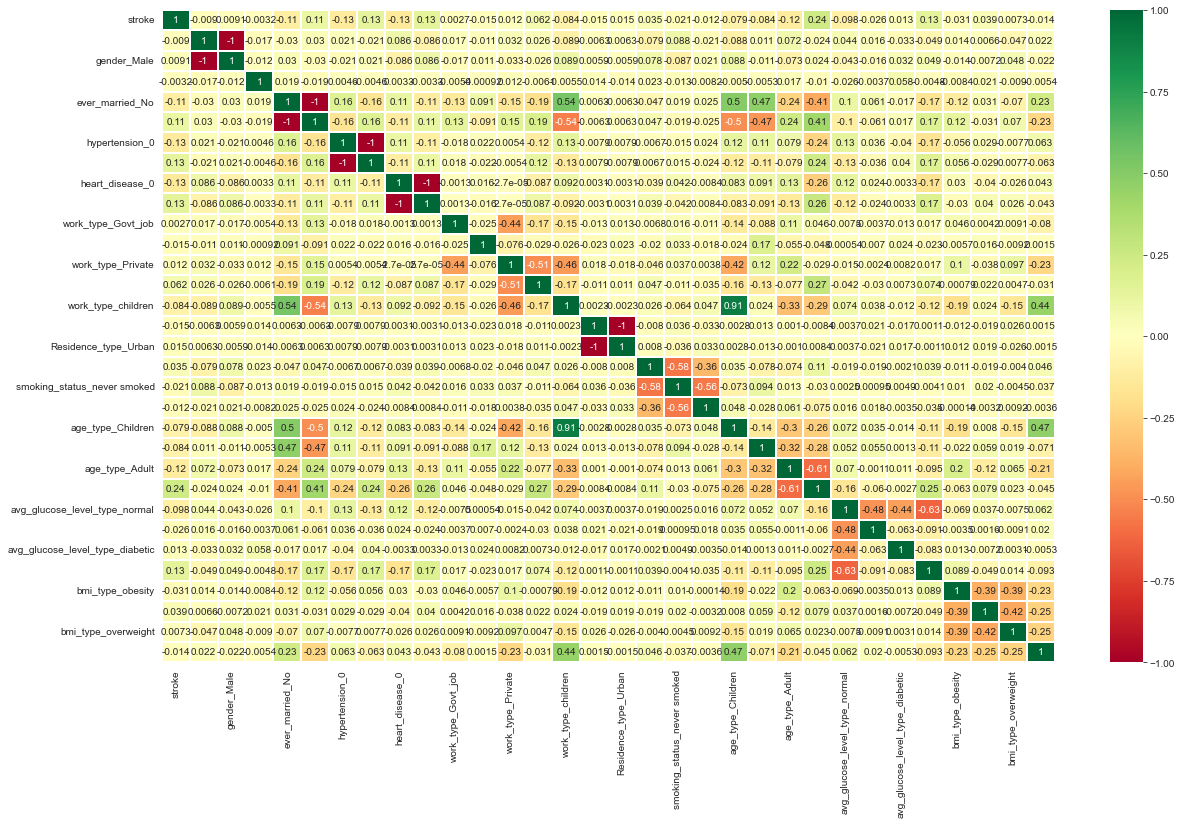

In [172]:
sns.heatmap(dummydf.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

Narysujemy pairplot

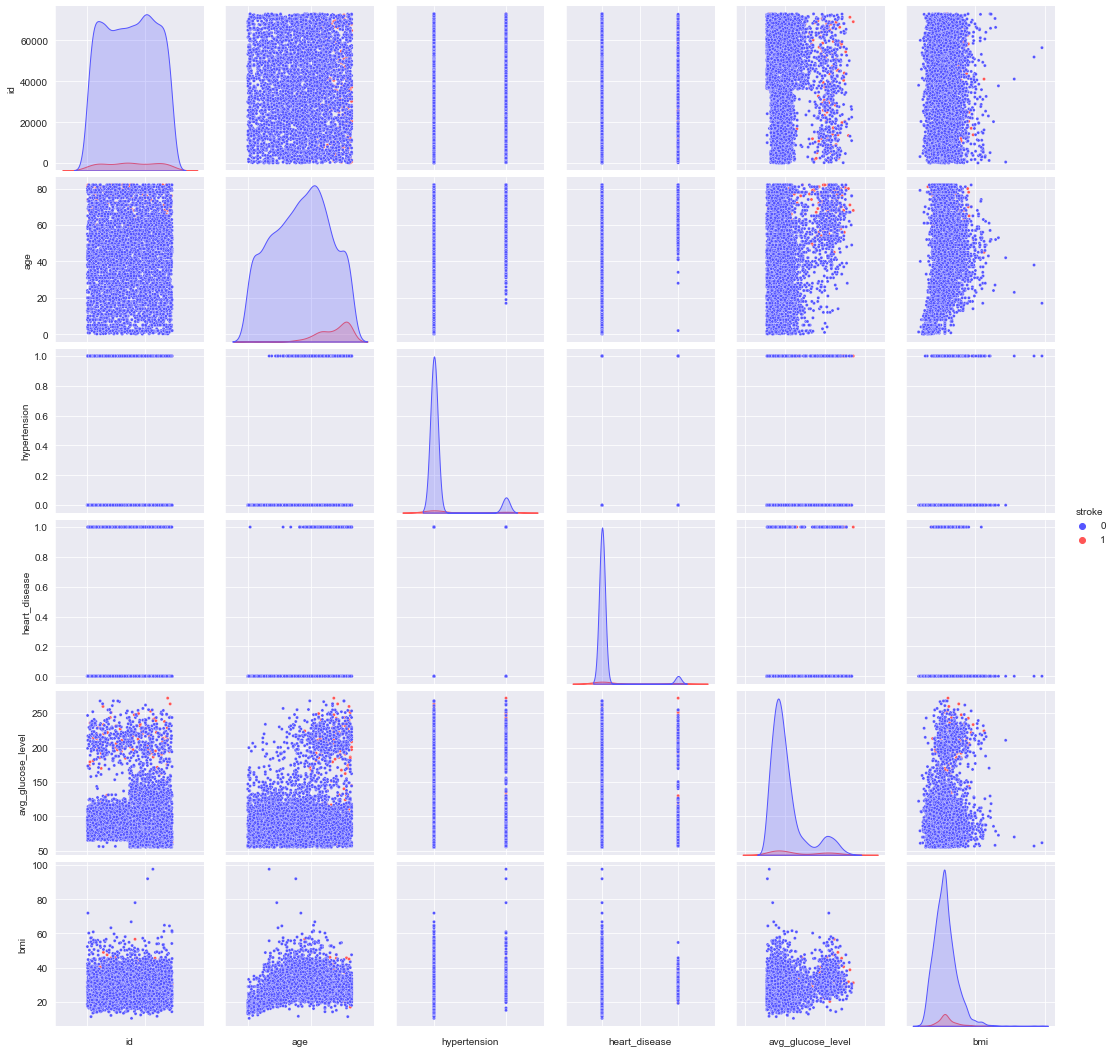

In [173]:
g = sns.pairplot(data=data, hue='stroke', palette = 'seismic',diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

Modelowanie

In [174]:
from sklearn.model_selection import train_test_split, StratifiedKFold  # for split the data
from sklearn.metrics import accuracy_score, recall_score  #for accuracy_score
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.metrics import confusion_matrix #for confusion matrix
kfold = StratifiedKFold(n_splits=10, random_state=123,shuffle=True)

In [175]:
all_features = dummydf.drop("stroke",axis=1)
all_features

,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,hypertension_0,hypertension_1,heart_disease_0,heart_disease_1,work_type_Govt_job,...,age_type_Adult,age_type_Elder,avg_glucose_level_type_normal,avg_glucose_level_type_pre_diabetic,avg_glucose_level_type_diabetic,avg_glucose_level_type_very_diabetic,bmi_type_obesity,bmi_type_optimum,bmi_type_overweight,bmi_type_underweight
0,0,1,0,0,1,1,0,0,1,0,...,0,1,0,0,0,1,1,0,0,0
1,1,0,0,0,1,1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
2,0,1,0,0,1,1,0,0,1,0,...,0,1,1,0,0,0,0,0,1,0
3,1,0,0,0,1,1,0,1,0,0,...,1,0,0,0,1,0,1,0,0,0
4,1,0,0,0,1,0,1,1,0,0,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,1,0,0,0,1,0,1,1,0,0,...,0,1,1,0,0,0,0,1,0,0
5106,1,0,0,0,1,1,0,1,0,0,...,0,1,0,1,0,0,1,0,0,0
5107,1,0,0,0,1,1,0,1,0,0,...,1,0,1,0,0,0,0,0,1,0
5108,0,1,0,0,1,1,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0


In [176]:
target = dummydf['stroke']
X_train,X_test,y_train,y_test = train_test_split(all_features,target,test_size=0.3,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((3577, 31), (1533, 31), (3577,), (1533,))

In [177]:
y_test

4688    0
4478    0
3849    0
4355    0
3826    0
       ..
818     0
4829    0
611     0
3082    0
3407    0
Name: stroke, Length: 1533, dtype: int64

Możemy teraz podjąć się trenowania i przewidywania. Mamy wiele modeli do wyboru. Za pomocą techniki supervised learning wytrenujemy i ocenimy każdy model. Najlepsze z nich wybierzemy do gridowania.

In [178]:
names = ['Logistic Regression',
              'Random Forest', 'Support Vector Machines','KNN','Decision Tree', 'AdaBoostClassifier',
              'Gradient Decent']
crosval_scores = []
accuracy_scores = []

Logistic Regression

--------------The Accuracy of the model----------------------------
The accuracy of the Logistic Regression is 94.19
The cross validated score for Logistic Regression is: 95.13


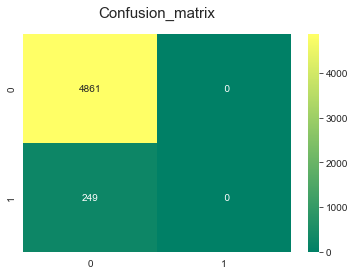

4688    0
4478    0
3849    0
4355    0
3826    0
       ..
818     0
4829    0
611     0
3082    0
3407    0
Name: stroke, Length: 1533, dtype: int64


In [179]:
from sklearn.linear_model import LogisticRegression # Logistic Regression

model = LogisticRegression()
model.fit(X_train,y_train)
prediction_lr=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Logistic Regression is',round(accuracy_score(y_test,prediction_lr)*100,2))
result_lr=cross_val_score(model,all_features,target,cv=kfold,scoring='accuracy')
print('The cross validated score for Logistic Regression is:',round(result_lr.mean()*100,2))
y_pred = cross_val_predict(model,all_features,target,cv=kfold)
sns.heatmap(confusion_matrix(target,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)
plt.show()
crosval_scores.append(round(result_lr.mean()*100,2))
accuracy_scores.append(round(accuracy_score(prediction_lr,y_test)*100,2))

print(y_test)

Random Forest Classifier

--------------The Accuracy of the model----------------------------
The accuracy of the Random Forest Classifier is 94.19
The cross validated score for Random Forest Classifier is: 95.11


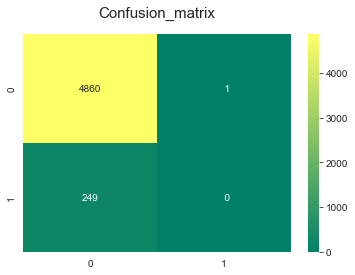

In [180]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(criterion='gini', n_estimators=700,
                             min_samples_split=10,min_samples_leaf=1,
                             max_features='auto',oob_score=True,
                             random_state=1,n_jobs=-1)
model.fit(X_train,y_train)
prediction_rm=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Random Forest Classifier is',round(accuracy_score(prediction_rm,y_test)*100,2))
result_rm=cross_val_score(model,all_features,target,cv=kfold,scoring='accuracy')
print('The cross validated score for Random Forest Classifier is:',round(result_rm.mean()*100,2))
y_pred = cross_val_predict(model,all_features,target,cv=kfold)
sns.heatmap(confusion_matrix(target,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)
plt.show()
crosval_scores.append(round(result_rm.mean()*100,2))
accuracy_scores.append(round(accuracy_score(prediction_rm,y_test)*100,2))

Support Vector Machines

--------------The Accuracy of the model----------------------------
The accuracy of the Support Vector Machines Classifier is 94.19
The cross validated score for Support Vector Machines Classifier is: 95.13


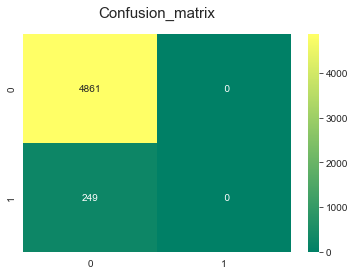

In [181]:
# Support Vector Machines
from sklearn.svm import SVC, LinearSVC

model = SVC()
model.fit(X_train,y_train)
prediction_svm=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Support Vector Machines Classifier is',round(accuracy_score(prediction_svm,y_test)*100,2))
result_svm=cross_val_score(model,all_features,target,cv=kfold,scoring='accuracy')
print('The cross validated score for Support Vector Machines Classifier is:',round(result_svm.mean()*100,2))
y_pred = cross_val_predict(model,all_features,target,cv=kfold)
sns.heatmap(confusion_matrix(target,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)
plt.show()
crosval_scores.append(round(result_svm.mean()*100,2))
accuracy_scores.append(round(accuracy_score(prediction_svm,y_test)*100,2))

KNN Classifier

--------------The Accuracy of the model----------------------------
The accuracy of the K Nearst Neighbors Classifier is 94.32
The cross validated score for K Nearest Neighbors Classifier is: 94.95


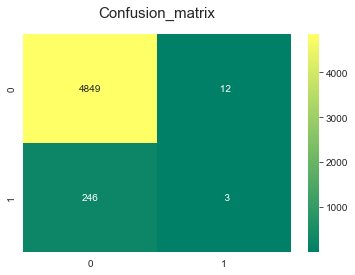

In [182]:
##knn
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors = 4)
model.fit(X_train,y_train)
prediction_knn=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the K Nearst Neighbors Classifier is',round(accuracy_score(prediction_knn,y_test)*100,2))
result_knn=cross_val_score(model,all_features,target,cv=kfold,scoring='accuracy')
print('The cross validated score for K Nearest Neighbors Classifier is:',round(result_knn.mean()*100,2))
y_pred = cross_val_predict(model,all_features,target,cv=kfold)
sns.heatmap(confusion_matrix(target,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)
plt.show()
crosval_scores.append(round(result_knn.mean()*100,2))
accuracy_scores.append(round(accuracy_score(prediction_knn,y_test)*100,2))

Decision Tree Classifier

--------------The Accuracy of the model----------------------------
The accuracy of the DecisionTree Classifier is 93.74
The cross validated score for Decision Tree classifier is: 94.72


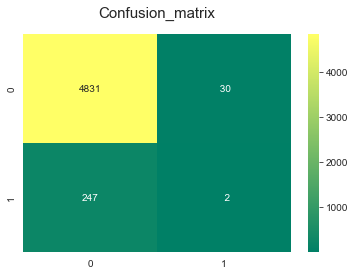

In [183]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
model= DecisionTreeClassifier(criterion='gini',
                             min_samples_split=10,min_samples_leaf=1,
                             max_features='auto')
model.fit(X_train,y_train)
prediction_tree=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the DecisionTree Classifier is',round(accuracy_score(prediction_tree,y_test)*100,2))
result_tree=cross_val_score(model,all_features,target,cv=kfold,scoring='accuracy')
print('The cross validated score for Decision Tree classifier is:',round(result_tree.mean()*100,2))
y_pred = cross_val_predict(model,all_features,target,cv=kfold)
sns.heatmap(confusion_matrix(target,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)
plt.show()
crosval_scores.append(round(result_tree.mean()*100,2))
accuracy_scores.append(round(accuracy_score(prediction_tree,y_test)*100,2))

AdaBoost

--------------The Accuracy of the model----------------------------
The accuracy of the AdaBoostClassifier is 94.19
The cross validated score for AdaBoostClassifier is: 95.13


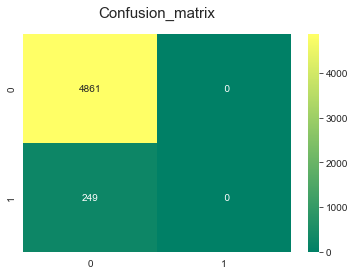

In [184]:
from sklearn.ensemble import AdaBoostClassifier
model= AdaBoostClassifier()
model.fit(X_train,y_train)
prediction_adb=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the AdaBoostClassifier is',round(accuracy_score(prediction_adb,y_test)*100,2))
result_adb=cross_val_score(model,all_features,target,cv=kfold,scoring='accuracy')
print('The cross validated score for AdaBoostClassifier is:',round(result_adb.mean()*100,2))
y_pred = cross_val_predict(model,all_features,target,cv=kfold)
sns.heatmap(confusion_matrix(target,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)
plt.show()
crosval_scores.append(round(result_adb.mean()*100,2))
accuracy_scores.append(round(accuracy_score(prediction_adb,y_test)*100,2))

Gradient Boosting Classifier

--------------The Accuracy of the model----------------------------
The accuracy of the Gradient Boosting Classifier is 94.13
The cross validated score for AdaBoostClassifier is: 95.03


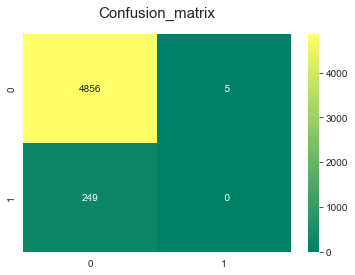

In [185]:
from sklearn.ensemble import GradientBoostingClassifier
model= GradientBoostingClassifier()
model.fit(X_train,y_train)
prediction_gbc=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Gradient Boosting Classifier is',round(accuracy_score(prediction_gbc,y_test)*100,2))
kfold = KFold(n_splits=10) # k=10, split the data into 10 equal parts
result_gbc=cross_val_score(model,all_features,target,cv=kfold,scoring='accuracy')
print('The cross validated score for AdaBoostClassifier is:',round(result_gbc.mean()*100,2))
y_pred = cross_val_predict(model,all_features,target,cv=kfold)
sns.heatmap(confusion_matrix(target,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)
plt.show()
crosval_scores.append(round(result_gbc.mean()*100,2))
accuracy_scores.append(round(accuracy_score(prediction_gbc,y_test)*100,2))

In [202]:
models = pd.DataFrame({
    'Model':names, 'Crossval score': crosval_scores, 'Accuracy': accuracy_scores
})
models.sort_values(by='Crossval score', ascending=False)

,Model,Crossval score,Accuracy
0,Logistic Regression,95.13,94.19
2,Support Vector Machines,95.13,94.19
5,AdaBoostClassifier,95.13,94.19
1,Random Forest,95.11,94.19
6,Gradient Decent,95.03,94.13
3,KNN,94.95,94.32
4,Decision Tree,94.72,93.74


Porównajmy wynik cross- walidacji dla recall u najlepszych modeli. Przewidujemy zawał- najbardziej zależy nam zatem na przewidzeniu jak największej ilości TP i jak najmniejszej FN. Jak się okazuje recall_lr = recall_svm = recall_adb. Mamy remis: wybierzmy zatem te trzy modele jako najlepsze- na nich będziemy gridować.

In [ ]:
models = [LogisticRegression(), SVC(), AdaBoostClassifier()]
kfold = StratifiedKFold(n_splits=5, random_state=123,shuffle=True)

Będziemy teraz tworzyć gridy. Będziemy rysować heatmapy, żeby upewnić się o poprawnym doborze parametrów

In [206]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

Fitting 5 folds for each of 28 candidates, totalling 140 fits


C:\Users\sch03\AppData\Local\Temp/ipykernel_16068/3265539545.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)


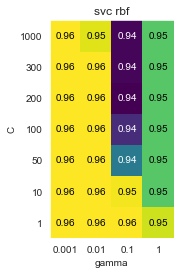

In [209]:
from sklearn.model_selection import GridSearchCV

# rbf
model= SVC()
param_grid_rbf = {'kernel': ['rbf'],
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

modelsvm_rbf = GridSearchCV(model,param_grid = param_grid_rbf, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

modelsvm_rbf.fit(X_train,y_train)
results = pd.DataFrame(modelsvm_rbf.cv_results_)
scores = np.array(results.mean_test_score).reshape(7,4)
heatmap(scores, xlabel='gamma', xticklabels=param_grid_rbf['gamma'], ylabel='C', yticklabels=param_grid_rbf['C'], cmap="viridis")
plt.title('svc rbf')
plt.show()

In [ ]:
# linear
model= SVC()
param_grid_linear = {'kernel': ['linear'],
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

modelsvm_linear = GridSearchCV(model,param_grid = param_grid_linear, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

modelsvm_linear.fit(X_train,y_train)
results = pd.DataFrame(modelsvm_linear.cv_results_)
scores = np.array(results.mean_test_score).reshape(7,4)
heatmap(scores, xlabel='gamma', xticklabels=param_grid_linear['gamma'], ylabel='C', yticklabels=param_grid_linear['C'], cmap="viridis")
plt.title('svc linear')
plt.show()

In [211]:
model= SVC()
param_grid = {'kernel': ['rbf','linear'],
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

modelsvm = GridSearchCV(model,param_grid = param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

modelsvm.fit(X_train,y_train)

print(modelsvm.best_estimator_)

# Best score
print(modelsvm.best_score_)

SVC(C=1, gamma=0.001)
0.9552697581747861
Fitting 5 folds for each of 56 candidates, totalling 280 fits
SVC(C=1, gamma=0.001)
0.9552697581747861


Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\sch03\anaconda3\envs\podstawy_sztucznej_inteligencji\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sch03\anaconda3\envs\podstawy_sztucznej_inteligencji\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sch03\anaconda3\envs\podstawy_sztucznej_inteligencji\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\sch03\anaco

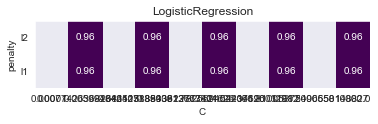

In [223]:
model = LogisticRegression()
param_grid = {'C':np.logspace(-4,4,10), 'penalty':['l1','l2']}
modellr = GridSearchCV(model,param_grid=param_grid,cv=kfold,scoring="accuracy", n_jobs= 4, verbose = 1)
modellr.fit(X_train,y_train)
results = pd.DataFrame(modellr.cv_results_)
scores = np.array(results.mean_test_score).reshape(2,10)
heatmap(scores, xlabel='C', xticklabels=param_grid['C'], ylabel='penalty', yticklabels=param_grid['penalty'], cmap="viridis")
plt.title('LogisticRegression')
plt.show()

In [224]:
print(modellr.best_estimator_)

# Best score
print(modellr.best_score_)

LogisticRegression(C=0.0001)
0.9552697581747861


In [222]:
#todo adaboost
model = AdaBoostClassifier()

param_grid = {
              'n_estimators' : [10,20,50,100,200,300,400],
              'learning_rate': [0.1, 0.05, 0.01,0.001]
}

modelabc = GridSearchCV(model, param_grid,scoring='f1',n_jobs=4,cv=kfold)
modelabc.fit(X_train,y_train)

KeyboardInterrupt: 

In [221]:
print(modelabc.best_estimator_)
# Best score
print(modelabc.best_score_)

AdaBoostClassifier(learning_rate=0.1, n_estimators=10)
0.0
